# Street View House Numbers - Evaluation on Test dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import svhn
import graphics
import keras_utils
from keras.utils import np_utils
import keras

%matplotlib inline

max_digits = 7
image_size = (32,77)

Using TensorFlow backend.


## Load test dataset
Here we load the sample points as individual prediction targets. We will not flatten the data like we did during training, since we have to predict the complete sequence of digits in an image together.

In [2]:
# load the data file (takes time)
rawdata = svhn.read_process_h5('../inputs/test/digitStruct.mat')

In [3]:
# extract resized images, counts and label sequences for each sample
def generateTestData(data, n=100):
    Ximg = []
    ycount = []
    ylabel = []
    for datapoint in np.random.choice(data, size=n):
        img,rawsize = svhn.createImageData(datapoint, image_size, '../inputs/test/')
        Ximg.append(img)
        ycount.append(datapoint['length'])
        ylabel.append(datapoint['labels'])
        
    ylabel = [[0 if y==10 else int(y) for y in ys] for ys in ylabel]
    return np.array(Ximg), np.array(ycount), np.array(ylabel)
    
Ximg, ycount, ylabel = generateTestData(rawdata, 1000)

## Load models
Our training graph is composed of individual models - vision, counter and label detector. While it was suitable for training on flattened data, we will need to organize the models differently to generate sequence predictions.
Extract the models from parent graph.

In [4]:
model_yaml = open('../checkpoints/model.yaml','r')
model = keras.models.model_from_yaml(model_yaml.read())
model_yaml.close()
model.load_weights('../checkpoints/model.hdf5')

# enumerate the layers of main graph
for i,layer in zip(range(len(model.layers)), model.layers):
    print "layer {} : {}".format(i,layer.name)

layer 0 : train_input_img
layer 1 : vision
layer 2 : train_input_idx
layer 3 : counter
layer 4 : detector


In [5]:
# extract the individual models from training graph
vision = model.layers[1]
counter = model.layers[3]
detector = model.layers[4]

## Prediction
For prediction, we will first generate the intermediate output h, from vision model. We will then pass it to counter first. Then the detector will be called for each sample with all indices in one go. 

The crucial part here is that we want to calculate the intermediate output h only once to save on computations.

In [6]:
h = vision.predict(Ximg)

In [7]:
ycount_ = counter.predict(h)
ycount_ = np.argmax(ycount_, axis=1)

In [8]:
ylabel_ = []
for i in range(len(ycount_)):
    # generate range for each count
    indices = np.arange(ycount_[i])
    # one hot encoding for each index
    indices = np_utils.to_categorical(indices, max_digits)
    # tile h to match shape of indices matrix
    hs = np.tile(h[i], (ycount_[i],1))
    
    # predict labels for the sample
    sample_seq = detector.predict([hs, indices])
    sample_seq = np.argmax(sample_seq,1)
    ylabel_.append(sample_seq)

In [9]:
print ylabel[1]
print ylabel_[1]

[1, 7]
[1 1]


## Evaluation
We can evaluate the performance of both counter and label detector to get a better insight on the fit. In the end, we will evaluate the performance of the whole system. We will consider a predicted sequence to be correct only if all labels have been identified successfully, as any wrong classification can result in a totally different house number.

### Counter Metrics

In [10]:
from sklearn.metrics import classification_report
print classification_report(ycount, ycount_)

             precision    recall  f1-score   support

          1       0.00      0.00      0.00       188
          2       0.64      1.00      0.78       635
          3       0.00      0.00      0.00       161
          4       0.00      0.00      0.00        16

avg / total       0.40      0.64      0.49      1000



/Users/devin/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Detector Metrics
Here we need to presume that counter has made a perfect prediction. If the counter itself has predicted wrong count, then it shouldn't be counted as detector's failure. So we'll evaluate the detector's performance for digits in a sequence till an index such that index is the minimum of true count value and predicted count value.

In [11]:
ycmin = np.minimum(ycount, ycount_)

# extract labels from ylabel and ylabel_ using ycmin
ylabel_det = np.array([ylabelrow[0:ycminc] for ylabelrow,ycminc in zip(ylabel, ycmin)])
ylabel_det = np.concatenate(ylabel_det)

ylabel_det_= np.array([ylabelrow[0:ycminc] for ylabelrow,ycminc in zip(ylabel_, ycmin)])
ylabel_det_= np.concatenate(ylabel_det_)

In [12]:
print classification_report(ylabel_det, ylabel_det_)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       115
          1       0.20      1.00      0.34       367
          2       0.00      0.00      0.00       308
          3       0.00      0.00      0.00       203
          4       0.00      0.00      0.00       174
          5       0.00      0.00      0.00       159
          6       0.00      0.00      0.00       130
          7       0.00      0.00      0.00       139
          8       0.00      0.00      0.00       101
          9       0.00      0.00      0.00       116

avg / total       0.04      0.20      0.07      1812



### Overall Sequence Prediction Accuracy

In [13]:
def matchSequence(seq, seq_):
    return [np.array_equal(seqi, seqi_) for seqi, seqi_ in zip(seq, seq_)]
seqmatch = matchSequence(ylabel, ylabel_)
print "Sequence prediction accuracy : {}".format(np.average(seqmatch))

Sequence prediction accuracy : 0.007


## Display samples

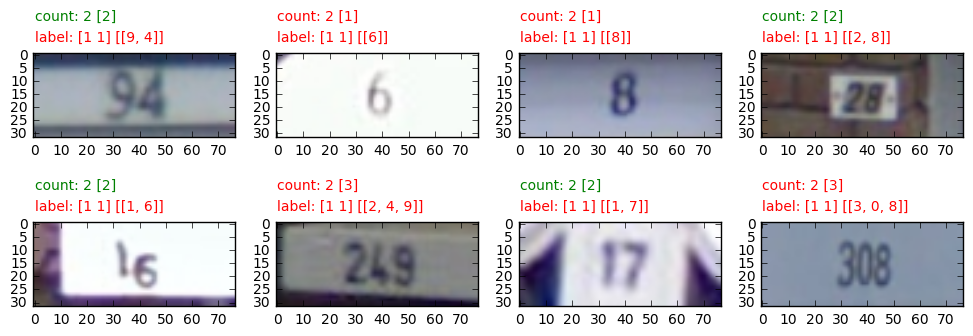

In [19]:
graphics.displaySamples(Ximg, ycounttrue=ycount, ycountpred=ycount_, ylabels=ylabel, ylabelspred=ylabel_)

## Visualize Convolutions

In [18]:
reload(graphics)

<module 'graphics' from 'graphics.py'>

In [ ]:
plt.imshow(Ximg[4])
print ylabel[4]